# TCO Calculation

This jupyter notebook executes a Total Cost of Ownership (TCO) calculation comparing the Solectrac Compact Electric Tractor (CET) with compact internal combustion tractors (<40 horsepower) 
A full description of this analysis can be found [here](https://static1.squarespace.com/static/5eab584a296dca09a66e85a6/t/627946f6c12c786debe434c7/1652115191705/TCO_report_May+2022.pdf)

In order to complete the calculation, this notebook requires the "Tractor_input.xlsx" excel file to be available. 

The Tractor_input file contains 3 sheets
1) "Input Parameters" which contains general parameters like the overall life of the tractor, the annual operating time, the baseline energy/fuel costs, and financing parameters like APR and financing term.
2) "Tractor Specs" which contains information about individual tractors such as their price and rated power. The sheet currently includes 16 tractors but new tractors can be included simply by adding them to this sheet.
3) "Implement Specs" which contains information about tractor attachments including their cost and the power required at the PTO

### The TCO calculation breaks the total cost down into 4 distinct sections
1) Initial Vehicle Costs (including implements)
2) Energy Costs ( Fuel or electricity depending on the powertrain)
3) Maintenance and Repair Costs
4) Financing Costs


An initial analysis is conducted based on the values entered in the "Tractor_input" excel sheet and then a sensitivity analysis is conducted which explores how cost varies within a given range for each of the input parameters 


#### To run the full analysis select the run all option on the top ribbon 

## 1.0 - Importing relevant information

In [2]:
# This section imports the relevent python libraries and input data 

import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install openpyxl
!{sys.executable} -m pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy 
import seaborn as sns 
pd.options.display.float_format = '{:,.2f}'.format
# The file path to the "Tractor_input.xlsx" file must be updated if this script is run on
# a new machine
path_to_tractor_input_file='Tractor_input.xlsx'

tractor_input_data=pd.read_excel(path_to_tractor_input_file,engine='openpyxl',sheet_name='Tractor Specs')
implement_input_data=pd.read_excel(path_to_tractor_input_file,engine='openpyxl',sheet_name='Implement Specs')
parameter_input_data=pd.read_excel(path_to_tractor_input_file,engine='openpyxl',sheet_name='Input Parameters')


In [3]:
# This section reads in all the relevant parameters from the input excel sheet 

# Read in baseline parameters 
projectLife=parameter_input_data.iloc[0]['Value']
operatingTimeAnnual= parameter_input_data.iloc[1]['Value']


# Read in energy prices
fuel_price_gal=parameter_input_data.iloc[2]['Value'] #($/gal)
electricityPrice=parameter_input_data.iloc[3]['Value'] #($/kwh)
charging_loss=0.10 # assume that 10 percent of energy drawn from the grid is lost to charging losses

#read in financing parameters
n = parameter_input_data.iloc[6]['Value'] # (years)
APR= parameter_input_data.iloc[4]['Value'] # (-)
MPR=APR/12
down_payment_fracton = parameter_input_data.iloc[5]['Value'] #(-)
vehicle_salvage_value_perc = parameter_input_data.iloc[7]['Value'] # % percent of total value remaining at point of sale/end of life


# Code related to reading in tractor & implement parameters 
tractorNames=tractor_input_data[['Manufacturer','Model']]
tractorNames=tractorNames.iloc[1:]
print("Tractors availble for this TCO calculation")
display(tractorNames)

print(" "); print("Implements available for this TCO calculation")
implementNames=implement_input_data[['Manufacturer','Model','Type']]
display(implementNames)

def get_tractor_info (make, model):
    """
    This small function collects the relevent information for a specific make and model 
    of tractor selected from those available in the Tractor_input excel sheet. A list of
    potential tractors is available below this cell.
    The default code compares the Solectrac eUtility with the John Deere 2038R
    
    Input:
        make - Manfacturer of the tractor (string parameter, must be entered in "" marks)
        model - Model of the tractor (string parameter, must be entered in "" marks)
    
    Output:
        tractor - Array which holds info about the tractor, this will be input
                       for the TCO analysis
    """
    tractor=tractor_input_data[(tractor_input_data['Manufacturer']==make) & (tractor_input_data['Model']==model)]
    
    return tractor.iloc[0]

def get_implement_info (make, model):
    """
    This function is the same as get_tractor_info but it is for implements.
    
    Input:
        make - Manfacturer of the tractor (string parameter, must be entered in "" marks)
        model - Model of the tractor (string parameter, must be entered in "" marks)
    
    Output:
        implement - Array which holds the cost and required horse power of the implement,
                    this will be input for the TCO analysis
                       
    """
    implement_row=implement_input_data[(implement_input_data['Manufacturer']==make)& (implement_input_data['Model']==model) ]
    implement=[implement_row['Cost Max'].iloc[0], implement_row['Required Hp'].iloc[0]]
   
    return implement
                        

Tractors availble for this TCO calculation


,Manufacturer,Model
1,Solectrac,eUtility
2,Solectrac,Compact Electric
3,Kubota,B3150
4,Kubota,L3010
5,Kubota,L3130D
6,New Holland,T2220
7,Kioti,CK4010
8,Mahindra,1526
9,Mahindra,1626
10,Mahindra,Max 24


 
Implements available for this TCO calculation


,Manufacturer,Model,Type
0,Phoenix,M48-S,Finish Mower
1,Land Pride,RTR0542,Rotary Tiller
2,LEFA,RT115,Rotary Tiller


In [4]:
# This analysis by default compares the John Deer 2032R with the Solectrac CET tractor
# If you interested in other tractors then create a variable using the "get_tractor_info" function and the Tractor's
# Manufacturer & model as seen below

#Identify Tractor
CET=get_tractor_info('Solectrac','Compact Electric')
JD_2032R=get_tractor_info('John Deere','2032R')

#Identify Implements
M48S=get_implement_info('Phoenix',"M48-S")
RTR0542=get_implement_info('Land Pride', 'RTR0542')


## 2.0 Constructing the TCO Model

In [9]:
# This section defines a python class "scenario"  & the three scenarios
# used in this TCO analysis
# The scenario class determines what fraction of the tractors total runtime
# is used to perform various tasks (mowing, tilling, harvesting, transport)

class scenario:
    """Class indicating the e-tractor use scenario"""
    def __init__(self,mowFrac,tillFrac,harvestFrac,driveFrac):
        self.mowFrac=mowFrac
        self.tillFrac=tillFrac
        self.harvestFrac=harvestFrac
        self.driveFrac=driveFrac

        
# scenario_SF (small farm) describes a scenario where the compact tractor is
# one of the main working tools on the farm
scenario_SF=scenario(mowFrac=0.3,tillFrac=0.3,harvestFrac=0.0,driveFrac=0.4) 

# scenario_LF (large farm) describes a scenario where the compact tractor is 
# used more sparingly on a large farm primarily for mowing and transport tasks
scenario_LF=scenario(mowFrac=0.3,tillFrac=0.0,harvestFrac=0.0,driveFrac=0.7) 

#scenario_W (Work horse) describes an extreme scenario where the compact tractor 
# is only used for a high intensity task, tilling
scenario_W=scenario(mowFrac=0.0,tillFrac=1,harvestFrac=0.0,driveFrac=0.0)


In [10]:
#set implements used by tractor 
mower=M48S
tiller=RTR0542

In [11]:
# This section defines functions used to estimate fuel & oil use in IC tractors
# and electricity use in e-Tractors 

# Note that although all input powers have the units of kilowatt, tractor power
# on the Tractor_input excel sheet should be given with units of horsepower.
# The appropriate conversion happens within the notebook

def fuel_average(pPTO): 
    """
    This function calculates average fuel use (with units of liters diesel/ hour)
    for IC tractors. This formulation is obtained from  
    ASABE Agricultural Machinery Management ASAE EP496.3
    
    Inputs: 
        pPTO - power available at the PTO (units of kW)
    
    Outputs:
        qAvg - Average fuel efficiency (units of L/h)
    
    """
    
    qAvg=0.305*pPTO
     
    return qAvg #($L/hr)


def fuel_specific (pPTO,pPTO_s):
    
    """
    This function calculates specific fuel use (with units of liters diesel/hour)
    for IC tractors. Specific fuel use varies with power required by PTO and 
    engine throttle speed.
    
    This formulation was obtained from  from 
    "Method for Fuel Prediction for Specific Tractor Models" Grisso et al 2006
    
    Inputs:
        pPTO - power available at the PTO (units of kW)
        pPTO_S - power required at PTO for use of specific implement (units of kW)
    
    Outputs:
        qS -specific fuel consumption units of (L/h)
    """
    
    nPT =540 # partial throttle engine speed (rpm)
    nFT =540 # full throttle engine speed (rpm)
    n =(nPT/nFT) #ratio of partial throttle engine speed to full throttle engine speed at operating load 
    pFrac=(pPTO_s/pPTO) #fraction of equivelant PTO power available 
    ptm=(1-(-0.0045*n+ 0.00877*n))
    qS=(0.22*pFrac+0.096)*ptm*pPTO # specific fuel consumption (L/h)
   
    return qS #L/h

def oil_use (pRated):  #(kW)
    """
    This function calculates oil use (units of liters of oil/ hour) for an 
    IC tractor. 
    
    This formulation is obtained from 
    from ASABE Agricultural Machinery Management Data ASAE D497.7
    
    Inputs:
        pRated - Rated power of tractor (units of kW)
    """
    oilUse=0.00059*pRated+0.02169
    return oilUse # (L/h)


bat_cost=10000 #$ Battery replacement cost

#The following lines establish power use data for the eTractor performing various tasks
# These values are calculated based on field trials of the CET the calculation is available in the eTractor_energy_use.ipynb notebook
# all listed values are in watts 

# currently the frontloader data is being used for driving and the general values are being used for mowing 
# These values were calculated based on field data and calculations in the eTractor_energy_usage.py script

rototill_ePoweruse= 3267.6 #watt
general_ePoweruse=2569.29 #watt
arenaGroomer_ePoweruse=6170.77 #watt
frontLoader_ePoweruse=1447.146 #watt
dragHarrow_ePoweruse=2173.24 #watt 
bladScraper_ePoweruse=1948.17 #watt

# Set which power use factors are used for different operations
# in the future this can be expanded to include more farm operations
till_ePoweruse=arenaGroomer_ePoweruse
drive_ePoweruse=frontLoader_ePoweruse
mow_ePoweruse=rototill_ePoweruse

## Emissions

Emission factors (EFs) from Expanded Emission Factors for Agricultural and Mining Equipment in GREET® Full Life-Cycle Model,
Appendix B, Table B Tractor Agricultural tractors, 2020, 50 HP


In [12]:
# Create array with tractor emision factors
AgTractor_EF=pd.DataFrame(([2.1,75,76920,434,10.6,10.3,0.40,23.2,7.9,2.2,2.02])) #(g/MMBTU)
AgTractor_EF.index=['CH4','CO','CO2','NOx','PM10','PM2.5','SO2','VOC','BC','OC','N2O']
AgTractor_EF.columns=['Emission Factors (g/mmBtu diesel)']

MMBtu_per_gal_Diesel = 137381/(1000000) # Source US Energy Information Administration 
# (https://www.eia.gov/energyexplained/units-and-calculators/british-thermal-units.php)
liter_per_gal=3.79

# Create array with tractor emision factors per liter
AgTractor_emissions_per_liter=AgTractor_EF*MMBtu_per_gal_Diesel/liter_per_gal
AgTractor_emissions_per_liter.columns=['Emission Factors (g/L diesel)']
AgTractor_emissions_per_liter

# Global warming potential factors from IPCC Annual report 5 
GWP_factors=pd.DataFrame(([30,2.65,1,-11,0,0,0,4.5,900,-69,265])) #AR5 GWP100 from GREET # SO2 & PMs set to zero 
GWP_factors.index=['CH4','CO','CO2','NOx','PM10','PM2.5','SO2','VOC','BC','OC','N2O']
GWP_factors.columns=['Global warming potential relative to CO2 ']

# Create array with tractor emision factors per liter with units of CO2 equivelant
Ag_em_liter_CO2eq=AgTractor_emissions_per_liter*GWP_factors.values
Ag_em_liter_CO2eq.columns=['Emission Factors g Co2eq/L']
Ag_em_liter_CO2eq

,Emission Factors g Co2eq/L
CH4,2.28
CO,7.20
CO2,"2,788.22"
NOx,-173.05
PM10,0.00
PM2.5,0.00
SO2,0.00
VOC,3.78
BC,257.73
OC,-5.50


## Electricity Emissions 

Energy mix is based on 2019 data from https://www.oregon.gov/energy/energy-oregon/pages/electricity-mix-in-oregon.aspx

The GREET model only has specific data for natural gas, coal, petroleum, biomass, geothermal and nuclear power plants. The "other power plants" data was used for wind, solar, hydro, and waste power plants. This data assumes that the only emissions are CO2 at a rate of 2 g per kWh produced. 

In [13]:
# Create array with global warming potential factors
GWP_factors_e=pd.DataFrame(([85,7.65,19,0,0,0,14,1])) #AR5 GWP20 from GREET # SO2 & PMs set to zero 
GWP_factors_e.index=['CH4','CO','NOx','PM10','PM2.5','SOx','VOC','CO2']
GWP_factors_e.columns=['Global warming potential relative to CO2 ']

# Create array with US energy mix
Energy_types=['Natural Gas','Coal','Nuclear','Wind','Hydro','Solar','Biomass','Waste','Petroleum','Geothermal', 'Other - nonbiogenic','Other - Biogenic']
US_energy_mix=pd.DataFrame(([38.4,23.4,19.6,7.2,7,1.7,0.9,0.5,0.5,0.4,0,0])) # % of energy mix
US_energy_mix=US_energy_mix/100
US_energy_mix.index=Energy_types
US_energy_mix.columns=['fraction of total energy mix']

# Create array with Oregon energy mix 
OR_energy_mix=pd.DataFrame(([24.80,27.45,3.50,4.86,37.23,0.75,0.72,0.06,0.05,0.08,0.24,0.08])) # % of energy mix
OR_energy_mix=OR_energy_mix/100
OR_energy_mix.index=Energy_types
OR_energy_mix.columns=['fraction of total energy mix']

# Create array with associated electricity emissions for different energy sources 
Electricity_emissions=pd.DataFrame(np.zeros((8,12))) #g/kWh electricity at wall outlet
Electricity_emissions.index=['CH4','CO','NOx','PM10','PM2.5','SOx','VOC','CO2']
Electricity_emissions.columns=Energy_types
Electricity_emissions['Natural Gas']=[0.011513223,0.070500796,0.118555149,0.021959422,0.021398211,0.007613262,0.008304724,449.9525323]
Electricity_emissions['Coal']=[0.165756443,0.312085423,0.744617196,0.080401113,0.062554226,0.990125257,0.014049315,1037.619792]
Electricity_emissions['Nuclear']=[0,0,0,0,0,0,0,0]
Electricity_emissions['Wind']=[0,0,0,0,0,0,0,2.008131]
Electricity_emissions['Hydro']=[0,0,0,0,0,0,0,2.008131]
Electricity_emissions['Solar']=[0,0,0,0,0,0,0,2.008131]
Electricity_emissions['Biomass']=[0.118767554,1.242720491,0.713656704,0.077197131,0.07240507,0.695359445,0.033519586,-2.383926634]
Electricity_emissions['Waste']=[0,0,0,0,0,0,0,2.008131]
Electricity_emissions['Petroleum']=[0.037703562,0.534245765,3.88477747,0.254837062,0.227342403,2.40670685,0.096015086,954.6119221]
Electricity_emissions['Geothermal']=[0,0,0,0,0,0,0,95.65233631]
Electricity_emissions['Other - nonbiogenic']=[0,0,0,0,0,0,0,2.008131]
Electricity_emissions['Other - Biogenic']=[0,0,0,0,0,0,0,2.008131]

# Get total global warming potential for each energy source
Electricity_emissions_GWP=np.sum(Electricity_emissions*GWP_factors_e.values) # g CO2 eq/ kWh


# Create array with ghg emissions from different electricity providers
# These values are sourced from the Oregon DEQ
# https://www.oregon.gov/deq/aq/programs/Pages/GHG-Emissions.aspx

E_emmissions_by_provider=pd.DataFrame(([0.418,0.689,0.183,0.055,0.428,0.020]))
providers=['Portland General Electric (PGE)','Pacific Power (PacifiCorp)','Umatilla Electric Cooperative','Eugene Water & Electric Board (EWEB)','Calpine Energy Solutions', "Wasco Electric Cooperative"]
E_emmissions_by_provider.index=providers
E_emmissions_by_provider.columns=['Emissions (Metric Ton CO2eq/MWh)']

Electricity_emissions

,Natural Gas,Coal,Nuclear,Wind,Hydro,Solar,Biomass,Waste,Petroleum,Geothermal,Other - nonbiogenic,Other - Biogenic
CH4,0.01,0.17,0,0.00,0.00,0.00,0.12,0.00,0.04,0.00,0.00,0.00
CO,0.07,0.31,0,0.00,0.00,0.00,1.24,0.00,0.53,0.00,0.00,0.00
NOx,0.12,0.74,0,0.00,0.00,0.00,0.71,0.00,3.88,0.00,0.00,0.00
PM10,0.02,0.08,0,0.00,0.00,0.00,0.08,0.00,0.25,0.00,0.00,0.00
PM2.5,0.02,0.06,0,0.00,0.00,0.00,0.07,0.00,0.23,0.00,0.00,0.00
SOx,0.01,0.99,0,0.00,0.00,0.00,0.70,0.00,2.41,0.00,0.00,0.00
VOC,0.01,0.01,0,0.00,0.00,0.00,0.03,0.00,0.10,0.00,0.00,0.00
CO2,449.95,"1,037.62",0,2.01,2.01,2.01,-2.38,2.01,954.61,95.65,2.01,2.01


In [14]:
# This section describes relevent data for calculating maintenance and repair
# costs for tractors

# Maintenance and repair data is taken from the publication 
# "Costs of Owning and Operating Farm Machinery in the Pacific Northwest: 2011"
# by Kathleen Paninter at the University of Idaho

# Costs are converted to 2021 dollars using the Consumer Price Index (CPI)
# Maintenance and repair costs are expected to vary during the lifetime of
# the tractor so various annual costs are provided 

# Because this study is on compact tractors, data for Wheel Tractors with rated
# power less than 40 HP are included

# These estimates do NOT include fuel and oil costs

# Consumer Price Index from U.S. Labor Department's Bureau of Labor Statistics
# (used to bring all values to 2020 dollars)
CPIyear=np.arange(2010,2021,1)
CPI=pd.DataFrame([218.056,224.939,229.594,232.957,236.736,237.017,240.007,245.120,251.107,255.657,257.971], columns=['Annual CPI'],index=CPIyear)
inflationFactor_2011=CPI['Annual CPI'][2020]/CPI['Annual CPI'][2011]


hours_of_use=[50,150,250,350,450,550,650,750]
maintenance_25HP=pd.DataFrame(np.zeros((8,3)),columns=['Hours of Use', 'THII ($)', 'Maintenance and Repairs ($)'])
maintenance_25HP['Hours of Use']=hours_of_use
maintenance_25HP['THII ($)']=np.array([1221,1194,1176,1162,1150,1139,1130,1121])*inflationFactor_2011
maintenance_25HP['Maintenance and Repairs ($)']=np.array([2,17,48,94,155,231,323,430])*inflationFactor_2011

maintenance_28HP=pd.DataFrame(np.zeros((8,3)),columns=['Hours of Use', 'THII ($)', 'Maintenance and Repairs ($)'])
maintenance_28HP['Hours of Use']=hours_of_use
maintenance_28HP['THII ($)']=np.array([1437,1405,1383,1367,1353,1340,1329,1319])*inflationFactor_2011
maintenance_28HP['Maintenance and Repairs ($)']=np.array([2,20,56,110,182,272,380,506])*inflationFactor_2011

maintenance_35HP=pd.DataFrame(np.zeros((8,3)),columns=['Hours of Use', 'THII ($)', 'Maintenance and Repairs ($)'])
maintenance_35HP['Hours of Use']=hours_of_use
maintenance_35HP['THII ($)']=np.array([1796,1756,1729,1708,1691,1675,1662,1649])*inflationFactor_2011
maintenance_35HP['Maintenance and Repairs ($)']=np.array([3,25,70,138,228,340,475,633])*inflationFactor_2011


In [16]:
# Main TCO calculation is described in the function below

def runTCO(scenario,tractor,mower,tiller,electricityPrice=electricityPrice,fuel_price_gal=fuel_price_gal,operatingTimeAnnual=operatingTimeAnnual,
           initial_cost_factor=1,bat_cost=bat_cost,projectLife=projectLife,projectLife_factor=1, MPR=MPR,
           eEmissions='OR Mix', visualize=1 ):
    
    """
    This function contains the full TCO calculation and returns the
    resulting costs broken down by segment and vizualizes the results.
    
    Required Inputs:
        scenario -the scenario which will be analyzed ( class ) 
        tractor - the tractor for which the TCO analysis is being done (array)
        mower -  the mower implement utilized for the TCO (array)
        tiller - the tiller implement utilized for the TCO (array)
        
    Optional Inputs:
    These parameters have a default value based on the Tractor_inputs.xlsx file but can be altered
    for sensitivity analysis or generally to see the impact of changing a parameter
    
        electricityPrice - units of $/kwh
        fuel_price_gal - units of $/gal
        initial_cost_factor - Fraction of initial cost, values above 1 increase initial cost
        bat_cost - units of $/ battery
        projectLife - units of years
        MPR - Monthly percentage rate, used for calculating finacning costs. unit of $
        eEmissions - which enery mix is used, options are oregon mix ('OR MIX'), US mix ('US Mix')
                     or providers which holds the data from specific energy providers
        visualize - this parameter determines whether plots are created, plots are created if value == 1
    
    Outputs: 
        TCO_s - TCO using specific power usage (accounting for scenarios)
        TCO - TCO using average power usage
        Emissions - GHG emissions 
        cost_segments - An array with TCO per segment
    
    """
    
    projectLife=projectLife*projectLife_factor
    
# Vehicle cost

    vehicle_initial_cost= tractor['Base Cost Max']*initial_cost_factor # ($) 
    vehicle_implement_cost=mower[0]+tiller[0] # ($)
    if tractor['Type']=='E':
        vehicle_battery_cost= 0 #bat_cost # ($) based on Solectrac eUtility spec sheet 
    else:
        vehicle_battery_cost=0
    
    vehicle_salvage_value= (vehicle_initial_cost+vehicle_implement_cost)*(vehicle_salvage_value_perc)
    # fraction of value remaining at end of tractor life 
    
    ip_total =vehicle_initial_cost+ vehicle_implement_cost +vehicle_battery_cost # initial purchase total($)
    # initial purchase total cost
    
   
    
#Energy cost 
    
    if tractor['Type']=='IC':
        pPTO_hp = tractor['Power @ PTO'] # maximum Power@PTO (hp)
        pPTO_mower=mower[1] # power required by mower (HP)
        pPTO_tiller=tiller[1] # power required by tiller (HP)
        
        pPTO=pPTO_hp*0.7457 #  maximum Power@PTO (kw)
        pPTO_mow=pPTO_mower*0.7457 # power required by mower (kw)
        pPTO_till=pPTO_tiller*0.7457 # power required by tiller (kw)
        fuel_price=fuel_price_gal/3.78541 # ($/L) Convert gal to L
        
        #average fuel efficiency
        qAvg=fuel_average(pPTO) # (L/hr)
        
        
        # specific fuel efficiency      
        qS_drive=fuel_specific(pPTO,0) #(L/hr)
        qS_mow=fuel_specific(pPTO,pPTO_mow) #(L/hr)
        qS_till=fuel_specific(pPTO,pPTO_till) #(L/hr)
       # print('drive = {} g/h'.format(qS_drive*0.264172))
       # print('mow = {} g/h'.format(qS_mow*0.264172))
       # print('till = {} g/h'.format(qS_till*0.264172))
        
        
        #Total fuel required per year using average fuel use
        fuel_annual=qAvg*operatingTimeAnnual #(L)
        
        #Total fuel per year accounting for scenario
        fuel_annual_s=(scenario.driveFrac*qS_drive+scenario.mowFrac*qS_mow+scenario.tillFrac*qS_till)*operatingTimeAnnual #L
        
        #print(fuel_annual_s)
        
        #Annual fuel costs 
        fuel_cost_ann= fuel_annual* fuel_price #($/year)
        fuel_cost_ann_s=fuel_annual_s* fuel_price
        
        #total fuel for project life
        Energy_use_total=fuel_annual_s*projectLife #L diesel
        
#eTractor Section
    else:
        electricPower=tractor['Battery Pack']/tractor['Run time per battery']
        fuel_annual=electricPower*operatingTimeAnnual*(1+charging_loss) #kwh
        fuel_annual_s=((scenario.driveFrac*drive_ePoweruse+scenario.mowFrac*mow_ePoweruse+
                       scenario.tillFrac*till_ePoweruse)*(1+charging_loss)*operatingTimeAnnual)/1000 # kwh
    
        fuel_cost_ann=fuel_annual*electricityPrice  #($/year)
        fuel_cost_ann_s= fuel_annual_s* electricityPrice #($/year)
        
        #total energy for project life
        Energy_use_total=fuel_annual_s*projectLife  #kWh
        
    #print('Fuel annuel, fuel annual specific = {}, {}'.format(fuel_annual, fuel_annual_s))
   #Total fuel costs     

    energy_total= projectLife*fuel_cost_ann  
    energy_total_s=projectLife*fuel_cost_ann_s
    
  
     
# Maintenance & Repair costs


    if tractor["Power"]<19.4:
        maint_costs=maintenance_25HP
        
    elif tractor["Power"]<=23.2:
        maint_costs=maintenance_28HP
    
    elif tractor["Power"]>23.2:
        maint_costs=maintenance_25HP
    
    cumulative_hours=np.arange(0,projectLife*operatingTimeAnnual+operatingTimeAnnual,operatingTimeAnnual)
    cumulative_hours=cumulative_hours[1:]
    maint_costs_ann=np.zeros((1,len(cumulative_hours)))
    for i in range(0,len(cumulative_hours)):
        if cumulative_hours[i]<maint_costs['Hours of Use'][0]:
            maint_costs_ann[i]=maint_costs['Maintenance and Repairs ($)'][0]
        elif cumulative_hours[i]<=maint_costs['Hours of Use'][1]:
            maint_costs_ann[0][i]=maint_costs['Maintenance and Repairs ($)'][1]    
        elif cumulative_hours[i]<=maint_costs['Hours of Use'][2]:
            maint_costs_ann[0][i]=maint_costs['Maintenance and Repairs ($)'][2]    
        elif cumulative_hours[i]<=maint_costs['Hours of Use'][3]:
            maint_costs_ann[0][i]=maint_costs['Maintenance and Repairs ($)'][3]  
        elif cumulative_hours[i]<=maint_costs['Hours of Use'][4]:
            maint_costs_ann[0][i]=maint_costs['Maintenance and Repairs ($)'][4]   
        elif cumulative_hours[i]<=maint_costs['Hours of Use'][5]:
            maint_costs_ann[0][i]=maint_costs['Maintenance and Repairs ($)'][5] 
        elif cumulative_hours[i]<=maint_costs['Hours of Use'][6]:
            maint_costs_ann[0][i]=maint_costs['Maintenance and Repairs ($)'][6]
        elif cumulative_hours[i]>=maint_costs['Hours of Use'][7]:
            maint_costs_ann[0][i]=maint_costs['Maintenance and Repairs ($)'][7]
    

    #Calculate Oil Costs
    #This calculation assumes: 
        #An oil cost of $6.60 per liter 
        #That oil changes occur every 100 hours
        #That oil filters are changed every other oil change
        #That oil filters cost $10 per filter
    
    if tractor['Type']=='IC':
        
        bat_replacement_cost=0
       
        pRated=tractor["Power"]
        oil=oil_use(pRated) #L/h
        oil_annual=operatingTimeAnnual*oil #L
        oil_cost= 6.6 # $/L (from https://www.deere.com/en/tools/parts/oil-cost-calculator/)
        oilChangeFreq = 100 # (hours)
        numOilChange=operatingTimeAnnual/oilChangeFreq
        numOilFilter_ann=numOilChange/2
        costOilFilter= 10 #$ (from https://www.deere.com/en/tools/parts/oil-cost-calculator/)
        
        annualOilMaintenance=oil_annual*oil_cost+numOilFilter_ann*costOilFilter
 
    if tractor['Type']=='E':
        
        annualOilMaintenance = 0
        
        battery_capacity=tractor['Battery Pack'] #wH
        cycles_per_battery=3000
        num_cycles=fuel_annual_s*projectLife/(battery_capacity*tractor['DOD '])
        #total cycles for the project life
        num_battery_replacement=np.floor(num_cycles/cycles_per_battery)
        bat_replacement_cost=num_battery_replacement*bat_cost
        
        annualOilMaintenance=0
        
    
    maint_total= sum(maint_costs_ann[0])+annualOilMaintenance*projectLife+bat_replacement_cost # based on ASAE_D_497.7 total R&M cost over course of machine life
    
    
    repair = 0 #$/year

# Financing Cost
    
    if tractor['Type']=='IC': #assume 0 APR for IC tractors
        fc_total=0
    else:
        downPayment= vehicle_initial_cost*down_payment_fracton
        f_payment=  (vehicle_initial_cost-downPayment)*((MPR*(1+MPR)**n)/((1+MPR)**n-1))
    
        fc_total =(f_payment * n)-(vehicle_initial_cost-downPayment) 

    
# Insurance Costs 

# not currently accounting for insurance costs 
    Ins= 0 # $/year need to determine 
    Ins_total = Ins* projectLife # insurance costs 

# Taxes & Fees 

# not currently accounting for taxes and fees 
    reg =  0# / year
    
    rebate=0 
    tnf_total = reg*projectLife - rebate # taxes and fees total 
    
    
#Emissions 
    
    if tractor['Type']=='E':
        
        Emission_USmix=np.sum(Energy_use_total*US_energy_mix*Electricity_emissions_GWP.values.reshape(12,1)).values/10**6 #metric Tons CO2eq
        
        Emission_ORmix=np.sum(Energy_use_total*OR_energy_mix*Electricity_emissions_GWP.values.reshape(12,1)).values/10**6 #metric Tons CO2eq
 
        Emissions_provider= Energy_use_total*E_emmissions_by_provider/1000 #metric Tons CO2eq
        Emissions_provider.columns=['Emissions (Metric Ton CO2eq)']
        
        if eEmissions=='OR Mix':
            Emissions=Emission_ORmix
        elif eEmissions=='US Mix':
            Emissions=Emission_USmix  
        elif eEmissions== providers:
            Emissions=Emissions_provider    
        
    
    else:
        Emissions=np.sum(Energy_use_total*Ag_em_liter_CO2eq).values/(10**6) # Metric tons CO2eq
        
    
    #Visualization 
    if visualize ==1:

        bar_labels=['Initial Purchase', 'Energy Cost', 'Maintenance', 'Financing']

        plt.bar(bar_labels,[ip_total,energy_total_s, maint_total, fc_total])
        plt.xticks(rotation=45)
        plt.show()

        #plt.pie([ip_total,energy_total, maint_total, fc_total, Ins_total, tnf_total], labels=bar_labels)
        
        plt.show()
    TCO=ip_total+energy_total+maint_total+fc_total+Ins_total+tnf_total
    TCO_s=ip_total+energy_total_s+maint_total+fc_total+Ins_total+tnf_total
    
    cost_segments=[ip_total,energy_total_s, maint_total, fc_total]
    
    return TCO_s,TCO, Emissions,cost_segments




## 3.0 Running the TCO model

In [17]:
# Calculate TCO for the John Deere Tractor for 3 scenarios
JD_TCO_LF=runTCO(scenario_LF,JD_2032R,mower,tiller,visualize=0)
JD_TCO_SF=runTCO(scenario_SF,JD_2032R,mower,tiller,visualize=0)
JD_TCO_W=runTCO(scenario_W,JD_2032R,mower,tiller,visualize=0) 

# Calculate TCO for the CET for 3 scenarios
CET_TCO_LF=runTCO(scenario_LF,CET,mower,tiller,visualize=0)
CET_TCO_SF=runTCO(scenario_SF,CET,mower,tiller,visualize=0)
CET_TCO_W=runTCO(scenario_W,CET,mower,tiller,visualize=0)

In [22]:
# Create tables to display TCO results
TCO_result=pd.DataFrame(np.zeros((2,3)),dtype=object)
TCO_result.columns=['Large Farm Scenario', 'Small Farm Scenario', 'Workhorse Scenario']
TCO_result.index=['eTractor (Solectrac CET)', 'IC Tractor (JD2032R)']
TCO_result.loc['eTractor (Solectrac CET)']['Small Farm Scenario']=CET_TCO_SF[0]
TCO_result.loc['eTractor (Solectrac CET)']['Large Farm Scenario']=CET_TCO_LF[0]
TCO_result.loc['eTractor (Solectrac CET)']['Workhorse Scenario']=CET_TCO_W[0]
TCO_result.loc['IC Tractor (JD2032R)']['Small Farm Scenario']=JD_TCO_SF[0]
TCO_result.loc['IC Tractor (JD2032R)']['Large Farm Scenario']=JD_TCO_LF[0]
TCO_result.loc['IC Tractor (JD2032R)']['Workhorse Scenario']=JD_TCO_W[0]

print('Total Cost of Ownership over life of tractor ({} years)'.format(projectLife))
display(TCO_result)

# Create tables to display TCO results per 100 hours 
TCO_per_100_hours=TCO_result/(projectLife*operatingTimeAnnual/100)
print('');print('')
print( 'Total Cost of Ownership per 100 hours')
display(TCO_per_100_hours)


Total Cost of Ownership over life of tractor (7.0 years)


,Large Farm Scenario,Small Farm Scenario,Workhorse Scenario
eTractor (Solectrac CET),"39,853.53","40,153.60","40,738.11"
IC Tractor (JD2032R),"37,535.61","39,420.56","43,072.03"




Total Cost of Ownership per 100 hours


,Large Farm Scenario,Small Farm Scenario,Workhorse Scenario
eTractor (Solectrac CET),"2,277.34","2,294.49","2,327.89"
IC Tractor (JD2032R),"2,144.89","2,252.60","2,461.26"


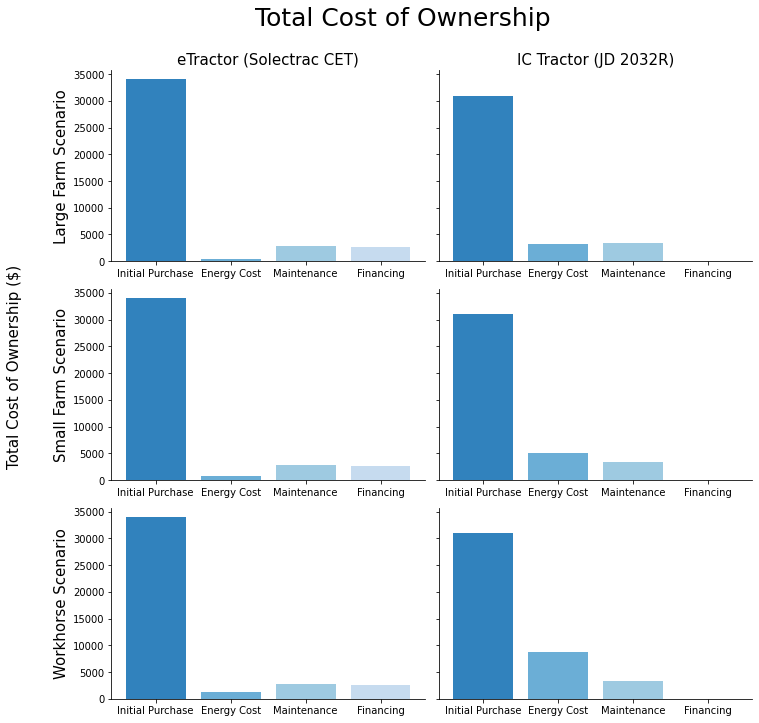

In [25]:
# Create plot of TCO costs per segment

bar_labels=['Initial Purchase', 'Energy Cost', 'Maintenance', 'Financing']
        
fig, axs= plt.subplots(3,2, sharey=True, figsize=(10,10))
fig.suptitle('Total Cost of Ownership', fontsize=25,y=1)
#fig.text(0.5, -0.05, 'Cost Segment', ha='center', fontsize=15)
fig.text(-0.05, 0.5, 'Total Cost of Ownership ($)', va='center', rotation='vertical',fontsize=15)
color_set=[]
for i in range (0,3):
    for j in range (0,2):
        axs[i,j].spines['top'].set_visible(False)
        axs[i,j].spines['right'].set_visible(False)

mycmap=plt.get_cmap('tab20c')
        
axs[0,0].bar(bar_labels,CET_TCO_LF[3], color=mycmap.colors)
axs[0,0].set_title('eTractor (Solectrac CET)',fontsize=15)
axs[0,0].set_ylabel('Large Farm Scenario',fontsize=15)
axs[1,0].bar(bar_labels,CET_TCO_SF[3], color=mycmap.colors)
axs[1,0].set_ylabel('Small Farm Scenario',fontsize=15)
axs[2,0].bar(bar_labels,CET_TCO_W[3], color=mycmap.colors)
axs[2,0].set_ylabel('Workhorse Scenario',fontsize=15)
axs[0,1].bar(bar_labels,JD_TCO_LF[3], color=mycmap.colors)
axs[0,1].set_title('IC Tractor (JD 2032R)',fontsize=15)
axs[1,1].bar(bar_labels,JD_TCO_SF[3], color=mycmap.colors)
axs[2,1].bar(bar_labels,JD_TCO_W[3], color=mycmap.colors)


plt.tight_layout()

# Uncomment the following line to save the figure 
#plt.savefig('TCO_fig.png',dpi=1200,bbox_inches='tight')

plt.show()

In [29]:
# Create tables of TCO cost per segment 

segment_compare_LF=pd.DataFrame(np.zeros((2,4)))
segment_compare_LF.columns=bar_labels
segment_compare_LF.index=['eTractor (Solectrac CET)','IC Tractor (JD 2032 R)']
segment_compare_LF.loc['eTractor (Solectrac CET)']=CET_TCO_LF[3]
segment_compare_LF.loc['IC Tractor (JD 2032 R)']=JD_TCO_LF[3]
print( 'TCO Costs per segment - Large Farm scenario')
display(segment_compare_LF)

segment_compare_SF=pd.DataFrame(np.zeros((2,4)))
segment_compare_SF.columns=bar_labels
segment_compare_SF.index=['eTractor (Solectrac CET)','IC Tractor (JD 2032 R)']
segment_compare_SF.loc['eTractor (Solectrac CET)']=CET_TCO_SF[3]
segment_compare_SF.loc['IC Tractor (JD 2032 R)']=JD_TCO_SF[3]
print('')
print( 'TCO Costs per segment - Small Farm scenario')
display(segment_compare_SF)

segment_compare_W=pd.DataFrame(np.zeros((2,4)))
segment_compare_W.columns=bar_labels
segment_compare_W.index=['eTractor (Solectrac CET)','IC Tractor (JD 2032 R)']
segment_compare_W.loc['eTractor (Solectrac CET)']=CET_TCO_W[3]
segment_compare_W.loc['IC Tractor (JD 2032 R)']=JD_TCO_W[3]
print('')
print( 'TCO Costs per segment - Workhorse scenario')
display(segment_compare_W)

TCO Costs per segment - Large Farm scenario


,Initial Purchase,Energy Cost,Maintenance,Financing
eTractor (Solectrac CET),"34,022.00",422.08,"2,785.70","2,623.76"
IC Tractor (JD 2032 R),"30,969.00","3,224.83","3,341.78",0.00



TCO Costs per segment - Small Farm scenario


,Initial Purchase,Energy Cost,Maintenance,Financing
eTractor (Solectrac CET),"34,022.00",722.15,"2,785.70","2,623.76"
IC Tractor (JD 2032 R),"30,969.00","5,109.78","3,341.78",0.00



TCO Costs per segment - Workhorse scenario


,Initial Purchase,Energy Cost,Maintenance,Financing
eTractor (Solectrac CET),"34,022.00","1,306.66","2,785.70","2,623.76"
IC Tractor (JD 2032 R),"30,969.00","8,761.25","3,341.78",0.00


## GHG emissions

In [30]:
# Create tables for GHG emissions
GHG_result=pd.DataFrame(np.zeros((2,3)),dtype=object)
GHG_result.columns=['Large Farm Scenario', 'Small Farm Scenario', 'Workhorse Scenario']
GHG_result.index=['eTractor (Solectrac CET)', 'IC Tractor (JD2032R)']
GHG_result.loc['eTractor (Solectrac CET)']['Small Farm Scenario']=CET_TCO_SF[2][0]
GHG_result.loc['eTractor (Solectrac CET)']['Large Farm Scenario']=CET_TCO_LF[2][0]
GHG_result.loc['eTractor (Solectrac CET)']['Workhorse Scenario']=CET_TCO_W[2][0]
GHG_result.loc['IC Tractor (JD2032R)']['Small Farm Scenario']=JD_TCO_SF[2][0]
GHG_result.loc['IC Tractor (JD2032R)']['Large Farm Scenario']=JD_TCO_LF[2][0]
GHG_result.loc['IC Tractor (JD2032R)']['Workhorse Scenario']=JD_TCO_W[2][0]
print('Greenhouse Gas Emissions over life of tractor ({} years) [Metric Tons CO2-eq]'.format(projectLife))
display(GHG_result)
print('');print('')

ghg_result_per_100_hours=GHG_result/(projectLife*operatingTimeAnnual/100)
print('Greenhouse Gas Emissions per 100 hours [Metric Tons CO2-eq]')
display(ghg_result_per_100_hours)


Greenhouse Gas Emissions over life of tractor (7.0 years) [Metric Tons CO2-eq]


,Large Farm Scenario,Small Farm Scenario,Workhorse Scenario
eTractor (Solectrac CET),1.56,2.68,4.84
IC Tractor (JD2032R),11.06,17.53,30.06




Greenhouse Gas Emissions per 100 hours [Metric Tons CO2-eq]


,Large Farm Scenario,Small Farm Scenario,Workhorse Scenario
eTractor (Solectrac CET),0.09,0.15,0.28
IC Tractor (JD2032R),0.63,1.00,1.72


In [31]:
# Create table for GHG emissions with different energy mixes

CET_TCO_SF_US=runTCO(scenario_SF,CET,mower,tiller, eEmissions='US Mix', visualize=0)
CET_TCO_LF_US=runTCO(scenario_LF,CET,mower,tiller,eEmissions='US Mix',visualize=0)
CET_TCO_W_US=runTCO(scenario_W,CET,mower,tiller,eEmissions='US Mix',visualize=0)

CET_TCO_SF_pr=runTCO(scenario_SF,CET,mower,tiller, eEmissions=providers, visualize=0)
CET_TCO_LF_pr=runTCO(scenario_LF,CET,mower,tiller,eEmissions=providers,visualize=0)
CET_TCO_W_pr=runTCO(scenario_W,CET,mower,tiller,eEmissions=providers,visualize=0)

eEmission_types=['Oregon Mix', 'US Mix']
eEmission_types.extend(providers)
eTractor_emissions=pd.DataFrame(np.zeros((8,3)))
eTractor_emissions.columns=['Large Farm Scenario', 'Small Farm Scenario', 'Workhorse Scenario']
eTractor_emissions.index=eEmission_types

eTractor_emissions.loc['Oregon Mix']['Small Farm Scenario']=CET_TCO_SF[2][0]
eTractor_emissions.loc['Oregon Mix']['Large Farm Scenario']=CET_TCO_LF[2][0]
eTractor_emissions.loc['Oregon Mix']['Workhorse Scenario']=CET_TCO_W[2][0]

eTractor_emissions.loc['US Mix']['Small Farm Scenario']=CET_TCO_SF_US[2][0]
eTractor_emissions.loc['US Mix']['Large Farm Scenario']=CET_TCO_LF_US[2][0]
eTractor_emissions.loc['US Mix']['Workhorse Scenario']=CET_TCO_W_US[2][0]

eTractor_emissions.loc[providers,'Small Farm Scenario']=CET_TCO_SF_pr[2].squeeze()
eTractor_emissions.loc[providers,'Large Farm Scenario']=CET_TCO_LF_pr[2].squeeze()
eTractor_emissions.loc[providers,'Workhorse Scenario']=CET_TCO_W_pr[2].squeeze()

display(eTractor_emissions)

,Large Farm Scenario,Small Farm Scenario,Workhorse Scenario
Oregon Mix,1.56,2.68,4.84
US Mix,1.65,2.83,5.11
Portland General Electric (PGE),1.60,2.74,4.97
Pacific Power (PacifiCorp),2.64,4.52,8.18
Umatilla Electric Cooperative,0.70,1.20,2.17
Eugene Water & Electric Board (EWEB),0.21,0.36,0.65
Calpine Energy Solutions,1.64,2.81,5.08
Wasco Electric Cooperative,0.08,0.13,0.24


## 4.0 Sensitivity Analysis

In [33]:
# Conduct a sensitivity analysis 

sens_factor=[0.80,0.85,0.90,0.95,1,1.05,1.10,1.15,1.20]

def SI_function(scenario,tractor,visualize=1):
    """
    This function conducts a sensitivity analysis 
    
    Inputs:
        Scenario - which scenario is used 
        Tractor - which tractor is used
        Visualize - whether plots should be created (1 == yes)
    
    Outputs:
        Sensitivity array - an array containing results of sensitivity analysis 
    
    """
    
    sensitivity_array=pd.DataFrame(np.zeros((6,len(sens_factor))))
    sensitivity_array.columns=['-20%','-15%','-10%','-5%','0%','5%','10%','15%','20%']
    sensitivity_array.index=['Fuel price','Electricity price','Annual operating hours','Initial purchase price', 'APR', 'Tractor life'] 
    
    for i in range(0,len(sens_factor)):
    
        TCO_o=runTCO(scenario,tractor,mower,tiller,fuel_price_gal=fuel_price_gal*sens_factor[i], visualize=0 )
        r=TCO_o[0]
        sensitivity_array.loc['Fuel price'].iloc[i]=r

    for i in range(0,len(sens_factor)):

        TCO_o=runTCO(scenario,tractor,mower,tiller,electricityPrice=electricityPrice*sens_factor[i], visualize=0 )
        r=TCO_o[0]
        sensitivity_array.loc['Electricity price'].iloc[i]=r

    for i in range(0,len(sens_factor)):

        TCO_o=runTCO(scenario,tractor,mower,tiller,operatingTimeAnnual=operatingTimeAnnual*sens_factor[i], visualize=0 )
        TCO_o=runTCO(scenario,tractor,mower,tiller,operatingTimeAnnual=operatingTimeAnnual*sens_factor[i], visualize=0 )
        r=TCO_o[0]
        sensitivity_array.loc['Annual operating hours'].iloc[i]=r

    for i in range(0,len(sens_factor)):

        TCO_o=runTCO(scenario,tractor,mower,tiller,initial_cost_factor=sens_factor[i], visualize=0 )
        r=TCO_o[0]
        sensitivity_array.loc['Initial purchase price'].iloc[i]=r

    #for i in range(0,len(sens_factor)):

       # TCO_o=runTCO(scenario,tractor,mower,tiller,bat_cost=bat_cost*sens_factor[i], visualize=0 )
       # r=TCO_o[0]
       # sensitivity_array.loc['replacement battery cost'].iloc[i]=r
        
    for i in range(0,len(sens_factor)):

        TCO_o=runTCO(scenario,tractor,mower,tiller,MPR=MPR*sens_factor[i], visualize=0 )
        r=TCO_o[0]
        sensitivity_array.loc['APR'].iloc[i]=r
     
    for i in range(0,len(sens_factor)):

        TCO_o=runTCO(scenario,tractor,mower,tiller,projectLife_factor=sens_factor[i], visualize=0 )
        r=TCO_o[0]
        sensitivity_array.loc['Tractor life'].iloc[i]=r
        
        
     #Visualization 
    if visualize ==1:
        
        for_plot=sensitivity_array.transpose()
        label=for_plot.columns
        plt.plot(for_plot)
        plt.legend(label)
        plt.show()

        
    return sensitivity_array


In [36]:
# Run sensitivity analysis 

sensitivity_analysis_e_SF=SI_function(scenario_SF,CET,visualize=0)
sensitivity_analysis_e_LF=SI_function(scenario_LF,CET,visualize=0)
sensitivity_analysis_e_W=SI_function(scenario_W,CET,visualize=0)
sensitivity_analysis_IC_SF=SI_function(scenario_SF,JD_2032R,visualize=0)
sensitivity_analysis_IC_LF=SI_function(scenario_LF,JD_2032R,visualize=0)
sensitivity_analysis_IC_W=SI_function(scenario_W,JD_2032R,visualize=0)

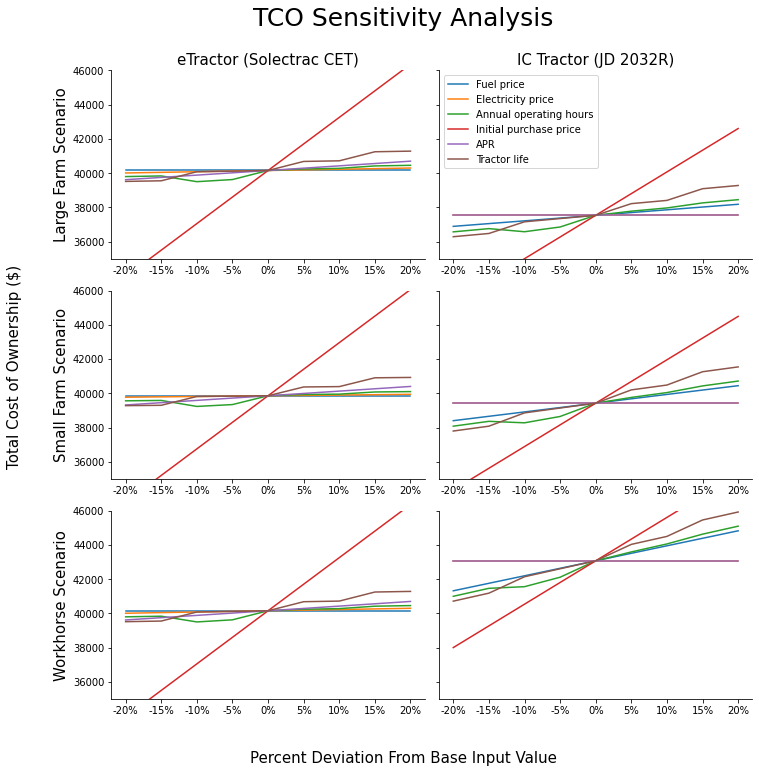

In [37]:
# plot results of sensitivity analysis 

fig, axs= plt.subplots(3,2, sharey=True, figsize=(10,10))
fig.suptitle('TCO Sensitivity Analysis', fontsize=25, y=1)

se1=sensitivity_analysis_e_SF.transpose()
se2=sensitivity_analysis_e_LF.transpose()
se3=sensitivity_analysis_e_W.transpose()
sIC1=sensitivity_analysis_IC_SF.transpose()
sIC2=sensitivity_analysis_IC_LF.transpose()
sIC3=sensitivity_analysis_IC_W.transpose()

fig.text(0.5, -0.05, 'Percent Deviation From Base Input Value', ha='center', fontsize=15)
fig.text(-0.05, 0.5, 'Total Cost of Ownership ($)', va='center', rotation='vertical',fontsize=15)
color_set=[]
for i in range (0,3):
    for j in range (0,2):
        axs[i,j].spines['top'].set_visible(False)
        axs[i,j].spines['right'].set_visible(False)


axs[0,0].plot(se1)
axs[0,0].axis(ymin=35000,ymax=46000)
axs[0,0].set_title('eTractor (Solectrac CET)',fontsize=15)
axs[0,0].set_ylabel('Large Farm Scenario',fontsize=15)
axs[1,0].plot(se2)
axs[1,0].set_ylabel('Small Farm Scenario',fontsize=15)
axs[2,0].plot(se1)
axs[2,0].set_ylabel('Workhorse Scenario',fontsize=15)
axs[0,1].plot(sIC2)
axs[0,1].set_title('IC Tractor (JD 2032R)',fontsize=15)
axs[1,1].plot(sIC1)
axs[0,1].legend(sIC2.columns)
axs[2,1].plot(sIC3)

plt.tight_layout()

# Uncomment the following line to save the figure 
#plt.savefig('Sensitivity.png',dpi=1200,bbox_inches='tight')

plt.show()

# Calculate Relative Sensitivity 

$$ SR = \large \frac{\frac{\Delta R}{R_{b}}}{\frac{\Delta P}{P_{b}}} $$


where $SR$ is Relative Sensitivity, $\Delta R$ is the difference between base $(R_{b})$ and perturbed
response value (in this case NPV), and $\Delta P$ is the difference between base $(P_{b})$ and perturbed
input parameter.

In [39]:
#  Calculate relative sensitivity
labels = ['Base Value', 'Perturbed Value', 'Response Value ($)', 'Relative Sensitivity']
SI_variables=['fuel price ($/gal)','electricity price ($/kWh)','annual operating time (hours)','initial purchase price ($)', 'APR (%)', 'Tractor Life (years)']

r_sensitivity_e = pd.DataFrame(np.zeros((6,4)))
r_sensitivity_e.columns=labels
r_sensitivity_e.index=SI_variables
r_sensitivity_e['Base Value']=[3.2,0.11,250,28398,4,7]
r_sensitivity_e['Perturbed Value']=r_sensitivity_e['Base Value']*1.1
r_sensitivity_e['Response Value ($)']=sensitivity_analysis_e_SF['10%'].values
r_sensitivity_e['Relative Sensitivity']=(r_sensitivity_e['Response Value ($)']-CET_TCO_SF[0])/CET_TCO_SF[0]/0.10

r_sensitivity_IC = pd.DataFrame(np.zeros((6,4)))
r_sensitivity_IC.columns=labels
r_sensitivity_IC.index=SI_variables
r_sensitivity_IC['Base Value']=[3.2,0.11,250,25345,4,7]
r_sensitivity_IC['Perturbed Value']=r_sensitivity_IC['Base Value']*1.1
r_sensitivity_IC['Response Value ($)']=sensitivity_analysis_IC_SF['10%'].values
r_sensitivity_IC['Relative Sensitivity']=(r_sensitivity_IC['Response Value ($)']-JD_TCO_SF[0])/JD_TCO_SF[0]/0.10

display(r_sensitivity_e)
display(r_sensitivity_IC)

,Base Value,Perturbed Value,Response Value ($),Relative Sensitivity
fuel price ($/gal),3.20,3.52,"40,153.60",0.00
electricity price ($/kWh),0.11,0.12,"40,225.81",0.02
annual operating time (hours),250.00,275.00,"40,278.57",0.03
initial purchase price ($),"28,398.00","31,237.80","43,255.78",0.77
APR (%),4.00,4.40,"40,425.08",0.07
Tractor Life (years),7.00,7.70,"40,718.96",0.14


,Base Value,Perturbed Value,Response Value ($),Relative Sensitivity
fuel price ($/gal),3.20,3.52,"39,931.53",0.13
electricity price ($/kWh),0.11,0.12,"39,420.56",0.00
annual operating time (hours),250.00,275.00,"40,039.90",0.16
initial purchase price ($),"25,345.00","27,879.50","41,955.06",0.64
APR (%),4.00,4.40,"39,420.56",0.00
Tractor Life (years),7.00,7.70,"40,480.29",0.27


# Extra calcualtions 

## E1. Rerun analysis with 2022 gas prices for a range of annual run times 

In [45]:
# set diesel price
fuel_price_now=4.6 #$/ gal
fuel_price_gal=fuel_price_now

# set range of hours ( 100 hours to 1000 hours per year)
run_hr_range=np.arange(100,1001,50)
plot_diff_hours=pd.DataFrame(np.zeros((len(run_hr_range),3)))
plot_diff_hours.columns=['Annual Operating Hours','TCO eTractor','TCO IC']
plot_diff_hours_d=pd.DataFrame(np.zeros((len(run_hr_range),3)))
plot_diff_hours_d.columns=['Annual Operating Hours','TCO eTractor','TCO IC']

counter=0
for h in run_hr_range:
    tco_et=runTCO(scenario_SF,CET,mower,tiller,operatingTimeAnnual=h,visualize=0)
    tco_ic=runTCO(scenario_SF,JD_2032R,mower,tiller,operatingTimeAnnual=h,visualize=0)
    plot_diff_hours.loc[counter,'Annual Operating Hours']=h
    plot_diff_hours.loc[counter,'TCO eTractor']=tco_et[0]
    plot_diff_hours.loc[counter,'TCO IC']=tco_ic[0]
    
    
    counter+=1
counter=0
for h in run_hr_range:
    tco_et=runTCO(scenario_SF,CET,mower,tiller,operatingTimeAnnual=h,visualize=0,fuel_price_gal=fuel_price_now)
    tco_ic=runTCO(scenario_SF,JD_2032R,mower,tiller,operatingTimeAnnual=h,visualize=0,fuel_price_gal=fuel_price_now)
    plot_diff_hours_d.loc[counter,'Annual Operating Hours']=h
    plot_diff_hours_d.loc[counter,'TCO eTractor']=tco_et[0]
    plot_diff_hours_d.loc[counter,'TCO IC']=tco_ic[0]
    
    
    counter+=1

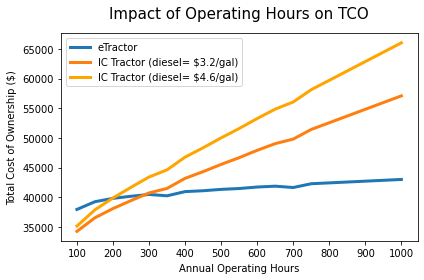

In [46]:
# plot results 

plt.plot(plot_diff_hours['Annual Operating Hours'],plot_diff_hours['TCO eTractor'], label= 'eTractor',linewidth=3)
plt.plot(plot_diff_hours['Annual Operating Hours'],plot_diff_hours['TCO IC'], label= 'IC Tractor (diesel= $3.2/gal)',linewidth=3)
#plt.plot(plot_diff_hours['Annual Operating Hours'],plot_diff_hours['TCO eTractor'], label= 'eTractor',linewidth=3)
plt.plot(plot_diff_hours['Annual Operating Hours'],plot_diff_hours_d['TCO IC'], label= 'IC Tractor (diesel= $4.6/gal)',linewidth=3, color='orange')

plt.xlabel('Annual Operating Hours', labelpad=5)
plt.ylabel('Total Cost of Ownership ($)', labelpad=5)
plt.xticks(np.arange(100,1001,100))
plt.title ('Impact of Operating Hours on TCO', pad=15, fontsize=15)
plt.legend()
plt.tight_layout()

# Uncomment the following  line to save figure 
#plt.savefig('TCO vs Operating Hours.png', dpi=1200)
